In [5]:
# Load canonical feature order and scaler params (if present)
import os, json

FEATURE_NAMES = globals().get("FEATURE_NAMES", None)
SCALER_PARAMS = globals().get("SCALER_PARAMS", {})
# candidate paths (repo-relative)
fo_cands = [
    "feature_order.json",
    "artifacts_aligned/feature_order.json",
    "./feature_order.json",
    "../feature_order.json",
    "advanced/submissions/team-members/rajan-hans/feature_order.json",
]
for p in fo_cands:
    if os.path.exists(p):
        try:
            with open(p, "r") as f:
                fo = json.load(f)
            if isinstance(fo, list) and len(fo) > 0:
                FEATURE_NAMES = fo
                print(f"Loaded FEATURE_NAMES from {p} (len={len(FEATURE_NAMES)})")
                break
        except Exception:
            pass

sp_cands = [
    "scaler_params.json",
    "artifacts_aligned/scaler_params.json",
    "./scaler_params.json",
    "../scaler_params.json",
    "advanced/submissions/team-members/rajan-hans/scaler_params.json",
]
for p in sp_cands:
    if os.path.exists(p):
        try:
            with open(p, "r") as f:
                sc = json.load(f)
            if isinstance(sc, dict):
                SCALER_PARAMS = sc
                print(f"Loaded SCALER_PARAMS from {p} (len={len(SCALER_PARAMS)})")
                break
        except Exception:
            pass

globals()["FEATURE_NAMES"] = FEATURE_NAMES
globals()["SCALER_PARAMS"] = SCALER_PARAMS
print("Canonical feature/scale loader complete.")


Loaded FEATURE_NAMES from feature_order.json (len=21)
Loaded SCALER_PARAMS from scaler_params.json (len=0)
Canonical feature/scale loader complete.


#### 1. Setup and Loading

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

sns.set_style("whitegrid")

# fetch dataset
datset = fetch_ucirepo(id=891)  # CDC Diabetes Health Indicators
# data (as pandas dataframes)
X = datset.data.features  # feature set
y = datset.data.targets  # target variable
# combine features and target into a single dataframe for easier analysis
df = pd.concat([X, y], axis=1)
# print(datset.variables.description)
# Programmatically merge df columns with datset.variables metadata
try:
    if (
        isinstance(datset.variables, pd.DataFrame)
        and "name" in datset.variables.columns
    ):
        df_columns = pd.DataFrame({"name": df.columns})
        merged = pd.merge(df_columns, datset.variables, on="name", how="left")
        pd.set_option("display.max_colwidth", None)
        display(merged)
    else:
        print("datset.variables is not a DataFrame with a 'name' column.")
        print(datset.variables)
except Exception as e:
    print("Error combining variables:", e)


name     role     type      demographic  \
0                 HighBP  Feature   Binary             None   
1               HighChol  Feature   Binary             None   
2              CholCheck  Feature   Binary             None   
3                    BMI  Feature  Integer             None   
4                 Smoker  Feature   Binary             None   
5                 Stroke  Feature   Binary             None   
6   HeartDiseaseorAttack  Feature   Binary             None   
7           PhysActivity  Feature   Binary             None   
8                 Fruits  Feature   Binary             None   
9                Veggies  Feature   Binary             None   
10     HvyAlcoholConsump  Feature   Binary             None   
11         AnyHealthcare  Feature   Binary             None   
12           NoDocbcCost  Feature   Binary             None   
13               GenHlth  Feature  Integer             None   
14              MentHlth  Feature  Integer             None   
15              PhysHlth  Feature  Integer             None   
16              DiffWalk  Feature   Binary             None   
17                   Sex  Feature   Binary              Sex   
18                   Age  Feature  Integer              Age   
19             Education  Feature  Integer  Education Level   
20                Income  Feature  Integer           Income   
21       Diabetes_binary   Target   Binary             None   

                                                                                                                                                                                                                                                                                                                                description  \
0                                                                                                                                                                                                                                                                                                                0 = no high BP 1 = high BP   
1                                                                                                                                                                                                                                                                                              0 = no high cholesterol 1 = high cholesterol   
2                                                                                                                                                                                                                                                                  0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years   
3                                                                                                                                                                                                                                                                                                                           Body Mass Index   
4                                                                                                                                                                                                                              Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes   
5                                                                                                                                                                                                                                                                                              (Ever told) you had a stroke. 0 = no 1 = yes   
6                                                                                                                                                                                                                                

#### 2. Data Integrity & Structure

In [7]:
print("--- 2. Data Integrity & Structure ---")
print("Missing values per column:")
print(df.isnull().sum())

print("\nTotal number of duplicate rows:", df.duplicated().sum())

print("\nDataFrame info:")
df.info()

print("\nNumber of unique values per column:")
print(df.nunique())


--- 2. Data Integrity & Structure ---
Missing values per column:
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64

Total number of duplicate rows: 24206

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680

#### 3. Target Variable Assessment ('Diabetes_binary')


--- 3. Target Variable Assessment ---
Percentage distribution of 'Diabetes_binary':
Diabetes_label
Non-Diabetes    86.066698
Pre/Diabetes    13.933302
Name: proportion, dtype: float64


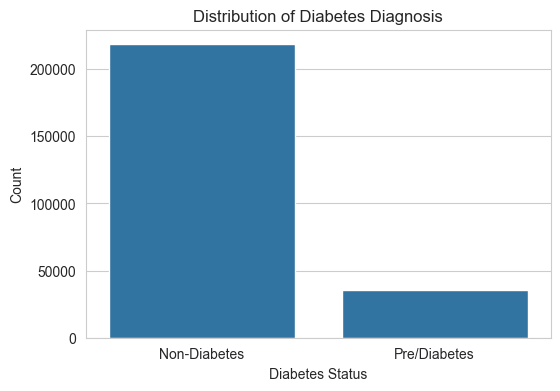

In [8]:
print("\n--- 3. Target Variable Assessment ---")
# Map values for readability
df["Diabetes_label"] = df["Diabetes_binary"].map({0: "Non-Diabetes", 1: "Pre/Diabetes"})
target_dist = df["Diabetes_label"].value_counts(normalize=True) * 100
print("Percentage distribution of 'Diabetes_binary':")
print(target_dist)

plt.figure(figsize=(6, 4))
sns.countplot(x="Diabetes_label", data=df)
plt.title("Distribution of Diabetes Diagnosis")
plt.xlabel("Diabetes Status")
plt.ylabel("Count")
plt.show()


#### 4. Feature Distribution & Quality


--- 4. Feature Distribution & Quality ---


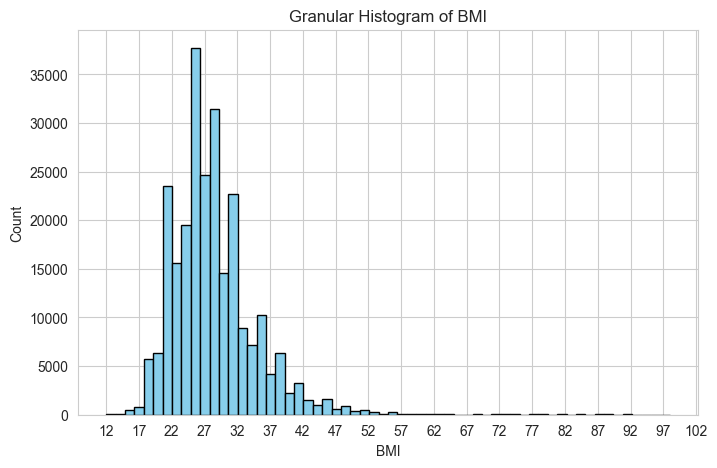

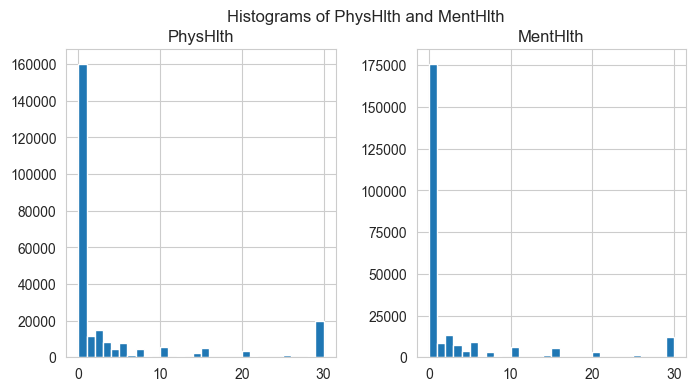

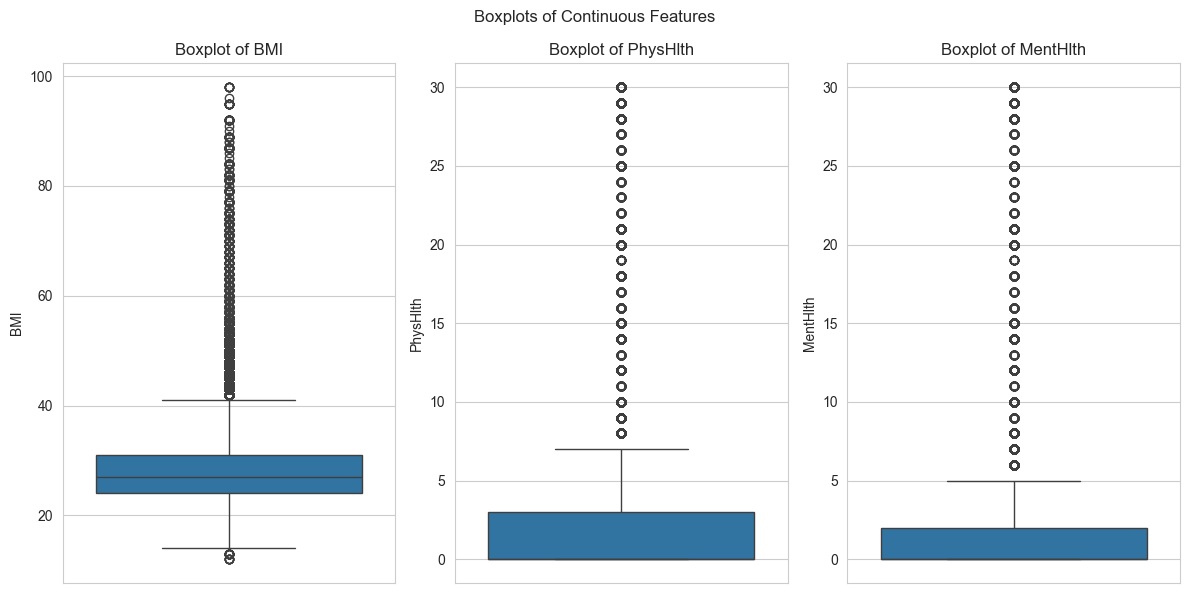


Descriptive statistics:
              HighBP       HighChol      CholCheck            BMI  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.429001       0.424121       0.962670      28.382364   
std         0.494934       0.494210       0.189571       6.608694   
min         0.000000       0.000000       0.000000      12.000000   
25%         0.000000       0.000000       1.000000      24.000000   
50%         0.000000       0.000000       1.000000      27.000000   
75%         1.000000       1.000000       1.000000      31.000000   
max         1.000000       1.000000       1.000000      98.000000   

              Smoker         Stroke  HeartDiseaseorAttack   PhysActivity  \
count  253680.000000  253680.000000         253680.000000  253680.000000   
mean        0.443169       0.040571              0.094186       0.756544   
std         0.496761       0.197294              0.292087       0.429169   
min         0.000000       0.000000              

In [9]:
print("\n--- 4. Feature Distribution & Quality ---")
cont_features = ["BMI", "PhysHlth", "MentHlth"]

# More granular BMI histogram with x-axis ticks in increments of 5
plt.figure(figsize=(8, 5))
plt.hist(df["BMI"], bins=60, color="skyblue", edgecolor="black")
plt.title("Granular Histogram of BMI")
plt.xlabel("BMI")
plt.ylabel("Count")
min_bmi = int(df["BMI"].min())
max_bmi = int(df["BMI"].max())
plt.xticks(np.arange(min_bmi, max_bmi + 5, 5))
plt.show()

# Histograms for other features
df[["PhysHlth", "MentHlth"]].hist(bins=30, figsize=(8, 4))
plt.suptitle("Histograms of PhysHlth and MentHlth")
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
for i, feature in enumerate(cont_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.suptitle("Boxplots of Continuous Features")
plt.tight_layout()
plt.show()

print("\nDescriptive statistics:")
print(df.describe())


**Boxplot Axes and Elements Explanation:**
- **Y-axis:** Shows the values of each feature (BMI, PhysHlth, MentHlth). Each boxplot visualizes the distribution of one feature.
- **Box:** Represents the interquartile range (IQR), which contains the middle 50% of the data.
- **Line inside the box:** Indicates the median value of the feature.
- **Whiskers:** Extend to the minimum and maximum values within 1.5 times the IQR from the quartiles.
- **Dots outside the whiskers:** Represent outliers—values that fall outside the whisker range.

Boxplots are useful for quickly visualizing the spread, central tendency, and presence of outliers in each feature.

**PhysHlth and MentHlth Histogram Axes Explanation:**

- **X-axis:** Represents the number of days in the past 30 days that a respondent reported poor physical health (`PhysHlth`) or poor mental health (`MentHlth`). The values range from 0 (no days) to 30 (all days in the month).
- **Y-axis:** Shows the count of respondents for each value or bin. In other words, it tells you how many people reported a given number of days of poor health.

These histograms help visualize how physical and mental health issues are distributed in the population, highlighting whether most people report few, many, or intermediate days of poor health.

**Box Plot Interpretation:**
The box plots below display the distribution of values for each continuous feature (BMI, PhysHlth, MentHlth):
- The box shows the interquartile range (IQR), which contains the middle 50% of the data.
- The line inside the box represents the median value.
- The whiskers extend to show the range of the data, excluding outliers.
- Points outside the whiskers are considered outliers.
This helps you visually assess the spread, central tendency, and presence of outliers for each feature.

#### 5. Feature Relationships & Patterns


--- 5. Feature Relationships & Patterns ---


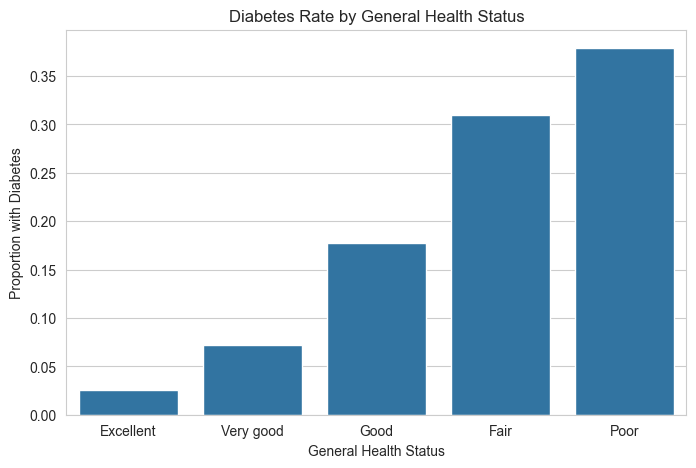

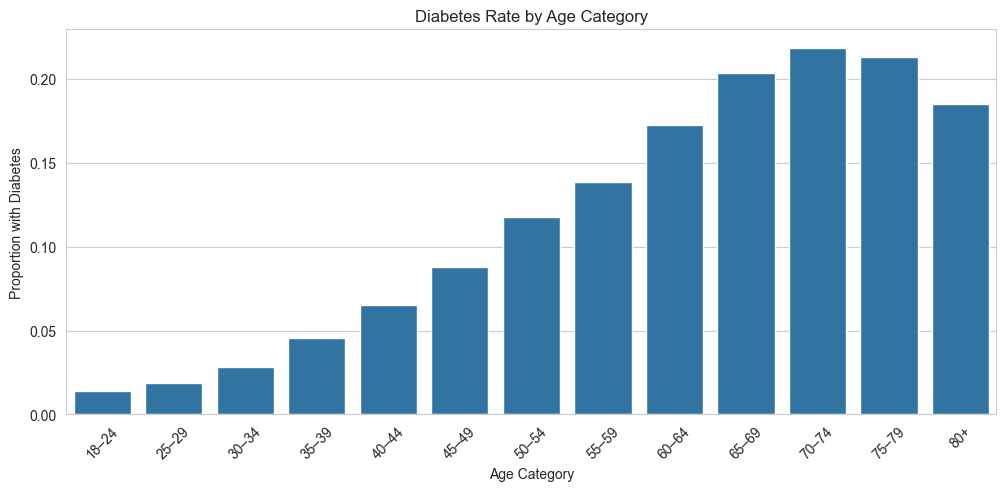

In [10]:
print("\n--- 5. Feature Relationships & Patterns ---")
# Diabetes rate by GenHealth
genhealth_labels = {1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"}
genhealth_rate = df.groupby("GenHlth")["Diabetes_binary"].mean().reset_index()
genhealth_rate["GenHlth"] = genhealth_rate["GenHlth"].astype(int)
genhealth_rate["GenHlth_label"] = (
    genhealth_rate["GenHlth"].map(genhealth_labels).fillna("Unknown")
)
plt.figure(figsize=(8, 5))
sns.barplot(x="GenHlth_label", y="Diabetes_binary", data=genhealth_rate)
plt.title("Diabetes Rate by General Health Status")
plt.ylabel("Proportion with Diabetes")
plt.xlabel("General Health Status")
plt.show()

# Diabetes rate by Age
age_labels = {
    1: "18–24",
    2: "25–29",
    3: "30–34",
    4: "35–39",
    5: "40–44",
    6: "45–49",
    7: "50–54",
    8: "55–59",
    9: "60–64",
    10: "65–69",
    11: "70–74",
    12: "75–79",
    13: "80+",
}
age_rate = df.groupby("Age")["Diabetes_binary"].mean().reset_index()
age_rate["Age"] = age_rate["Age"].astype(int)
age_rate["Age_label"] = age_rate["Age"].map(age_labels).fillna("Unknown")
plt.figure(figsize=(12, 5))
ax = sns.barplot(x="Age_label", y="Diabetes_binary", data=age_rate)
plt.title("Diabetes Rate by Age Category")
plt.ylabel("Proportion with Diabetes")
plt.xlabel("Age Category")
plt.xticks(rotation=45)
plt.show()


#### 6. Bivariate and Multivariate Analysis

**Bivariate Analysis**

- Explore relationships between two variables using scatter plots, boxplots, and barplots.
- Useful for understanding direct associations and group differences.

**Multivariate Analysis**

- Explore relationships among three or more variables using pairplots and heatmaps.
- Useful for uncovering complex patterns and interactions.

In [ ]:
# --- Bivariate Analysis ---

# 1. Scatter plot: BMI vs PhysHlth, colored by Diabetes status
plt.figure(figsize=(8, 6))
sns.scatterplot(x="BMI", y="PhysHlth", hue="Diabetes_label", data=df, alpha=0.5)
plt.title("BMI vs PhysHlth by Diabetes Status")
plt.xlabel("BMI")
plt.ylabel("PhysHlth")
plt.legend(title="Diabetes Status")
plt.show()

# 2. Boxplot: BMI by Diabetes status

plt.figure(figsize=(6, 4))
sns.boxplot(x="Diabetes_label", y="BMI", data=df)
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("Diabetes Status")
plt.ylabel("BMI")
plt.show()

# 3. Barplot: HighBP vs Diabetes status

plt.figure(figsize=(6, 4))
sns.barplot(x="HighBP", y="Diabetes_binary", data=df, ci=None)
plt.title("Diabetes Rate by High Blood Pressure")
plt.xlabel("High Blood Pressure (0=No, 1=Yes)")
plt.ylabel("Proportion with Diabetes")
plt.show()

# --- Multivariate Analysis ---

# 1. Pairplot of selected features colored by Diabetes status (lower triangle only)

selected_features = ["BMI", "PhysHlth", "MentHlth", "Age", "Diabetes_label"]

sns.pairplot(
    df[selected_features],
    hue="Diabetes_label",
    diag_kind="hist",
    plot_kws={"alpha": 0.5},
    corner=True,
)

plt.suptitle("Pairplot of Selected Features by Diabetes Status", y=1.02)

plt.show()


**Bivariate Analysis Explanations:**
- **Scatter Plot (BMI vs PhysHlth by Diabetes Status):**
    - Each point represents a respondent.
    - The x-axis shows BMI, the y-axis shows number of days of poor physical health.
    - Points are colored by diabetes status, helping visualize if higher BMI and poor physical health are associated with diabetes.
- **Boxplot (BMI by Diabetes Status):**
    - Shows the distribution of BMI for each diabetes group.
    - Useful for comparing median BMI and spread between groups.
- **Barplot (HighBP vs Diabetes Rate):**
    - Displays the proportion of respondents with diabetes for each blood pressure group (0=No, 1=Yes).
    - Helps assess if high blood pressure is associated with higher diabetes rates.

**Multivariate Analysis Explanations:**
- **Pairplot of Selected Features by Diabetes Status:**
    - Shows scatterplots and histograms for pairs of features (BMI, PhysHlth, MentHlth, Age), colored by diabetes status.
    - Useful for spotting patterns, clusters, and relationships across multiple variables.
- **Heatmap of Mean BMI by Age and High Blood Pressure:**
    - Each cell shows the average BMI for a specific age group and blood pressure status.
    - Color intensity indicates BMI level, helping identify which age and BP groups have higher average BMI.

These visualizations help uncover direct and complex relationships between features and diabetes, guiding further analysis and modeling.

#### 8.1 Heatmap of mean BMI for combinations of Age and HighBP

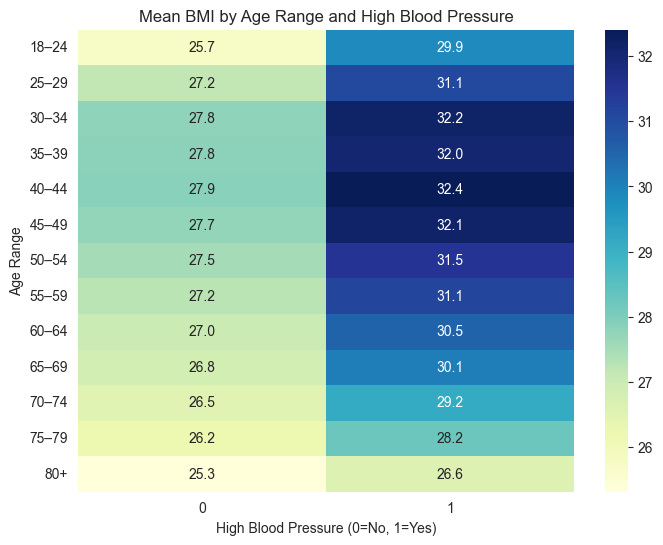

In [11]:
# 2. Heatmap of mean BMI for combinations of Age and HighBP
age_labels = {
    1: "18–24",
    2: "25–29",
    3: "30–34",
    4: "35–39",
    5: "40–44",
    6: "45–49",
    7: "50–54",
    8: "55–59",
    9: "60–64",
    10: "65–69",
    11: "70–74",
    12: "75–79",
    13: "80+",
}
pivot = df.pivot_table(index="Age", columns="HighBP", values="BMI", aggfunc="mean")
pivot.index = pivot.index.map(lambda x: age_labels.get(int(x), str(x)))
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Mean BMI by Age Range and High Blood Pressure")
plt.xlabel("High Blood Pressure (0=No, 1=Yes)")
plt.ylabel("Age Range")
plt.show()


**Heatmap of Mean BMI by Age and High Blood Pressure Explanation:**
- This heatmap visualizes the average BMI for each combination of age group and high blood pressure status.
- **Rows:** Represent different age categories.
- **Columns:** Represent high blood pressure status (0 = No, 1 = Yes).
- **Cell color:** Indicates the mean BMI for that age and blood pressure group; darker colors typically represent higher BMI values.
- This plot helps identify which age and blood pressure groups tend to have higher or lower average BMI, revealing patterns that may be important for understanding diabetes risk.

#### 8.2 Correlation Heatmap Matrix

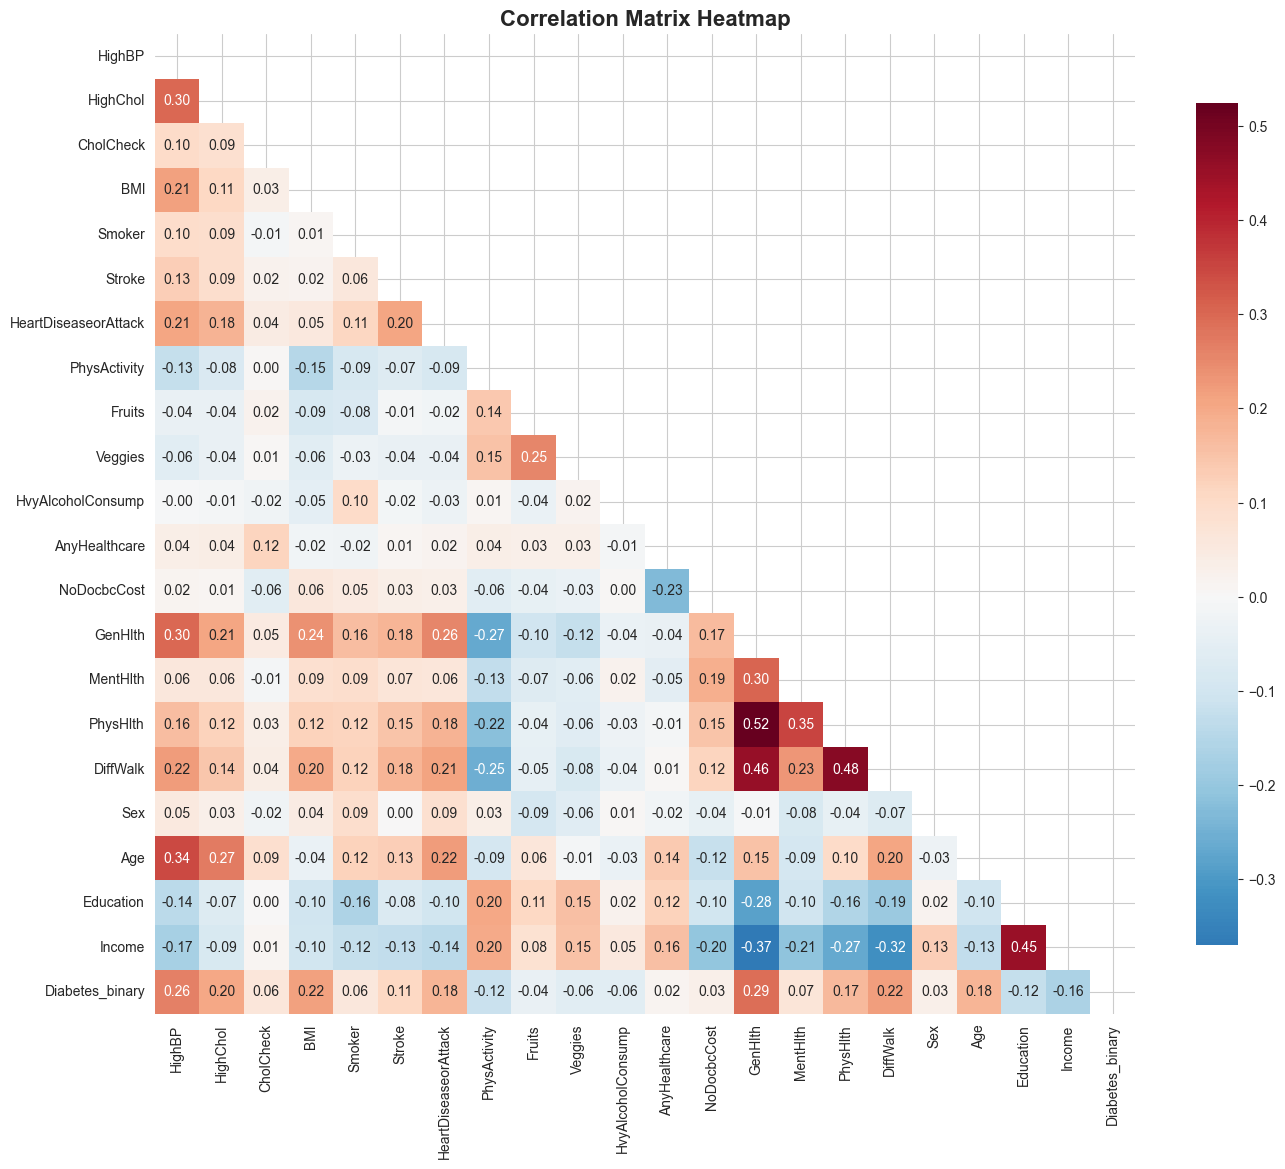


Highly Correlated Variable Pairs (|correlation| > 0.5):
GenHlth - PhysHlth: 0.524


In [12]:
# Calculate numeric correlation matrix
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix Heatmap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Threshold for high correlation
            high_corr_pairs.append(
                (correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val)
            )

if high_corr_pairs:
    print("\nHighly Correlated Variable Pairs (|correlation| > 0.5):")
    for var1, var2, corr in sorted(
        high_corr_pairs, key=lambda x: abs(x[2]), reverse=True
    ):
        print(f"{var1} - {var2}: {corr:.3f}")
else:
    print("\nNo highly correlated variable pairs found (threshold: 0.5)")


**Correlation Heatmap Interpretation:**
The heatmap above shows the pairwise correlation coefficients between all numeric features in the dataset.
- Values close to +1 indicate a strong positive correlation: as one feature increases, the other tends to increase.
- Values close to -1 indicate a strong negative correlation: as one feature increases, the other tends to decrease.
- Values near 0 indicate little or no linear relationship between features.
Key observations:
- Features like 'HighBP', 'BMI', and 'Age' show moderate positive correlations with 'Diabetes_binary', suggesting they are associated with diabetes risk.
- Some features (e.g., 'PhysHlth' and 'MentHlth') are also positively correlated, indicating that poor physical and mental health often occur together.
- Most features have low to moderate correlations, meaning multicollinearity is not a major issue, but some relationships are worth exploring further in modeling.

#### EDA Summary & Final Shape

In [13]:
print("\n--- EDA Summary & Final Shape ---")
original_shape = df.shape
num_duplicates = df.duplicated().sum()
cleaned_rows = df.shape[0] - num_duplicates

print(f"Original dataset shape: {original_shape}")
print(f"Number of duplicate rows found: {num_duplicates}")
print(f"Cleaned dataset shape will be: ({cleaned_rows}, {df.shape[1]})")
print("\nKey Takeaways:")
print("1. Significant class imbalance exists in 'Diabetes_binary'.")
print(
    "2. Features like 'GenHealth', 'HighBP', 'BMI', and 'Age' show strong relationships with the target."
)
print(
    "3. Continuous features ('BMI', 'PhysHlth', 'MentHlth') are right-skewed and have outliers."
)
print(
    "4. No missing data, but a large number of duplicates must be removed before modeling."
)



--- EDA Summary & Final Shape ---
Original dataset shape: (253680, 23)
Number of duplicate rows found: 24206
Cleaned dataset shape will be: (229474, 23)

Key Takeaways:
1. Significant class imbalance exists in 'Diabetes_binary'.
2. Features like 'GenHealth', 'HighBP', 'BMI', and 'Age' show strong relationships with the target.
3. Continuous features ('BMI', 'PhysHlth', 'MentHlth') are right-skewed and have outliers.
4. No missing data, but a large number of duplicates must be removed before modeling.
